**Imports** 

In [ ]:
!pip install --upgrade xlrd

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import losses
%matplotlib inline

**Load Data**

In [ ]:
des = pd.read_csv('/content/desired_10db_100000.csv', header=None)
dis = pd.read_csv('/content/distorted_10db_100000.csv', header=None)
print(len(dis), len(des))

100000 100000


In [ ]:
des.value_counts()

-1.0    50246
 1.0    49754
dtype: int64

**Create Samples**

In [ ]:
def create_samples(data):
    
    data = np.array(data)
    rn = len(data)
    sample = []
    xs = []

    if rn%16 == 0:
        pass
    else:
        rn = rn - rn%16

    start = 0
    end = rn
    # while end-start>16:
    for i in range(start,end,16):
        xs.append(data[i:i+16])

        sample.append(xs)
        xs = []
        # start += 8
        # end -= 8

    sample = np.array(sample)
    l = len(sample)
    sample = sample.reshape(l, 16, 1)
    return(sample)

In [ ]:
desired = create_samples(des)
distorted = create_samples(dis)

In [ ]:
print(desired.shape, distorted.shape)

(6250, 16, 1) (6250, 16, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


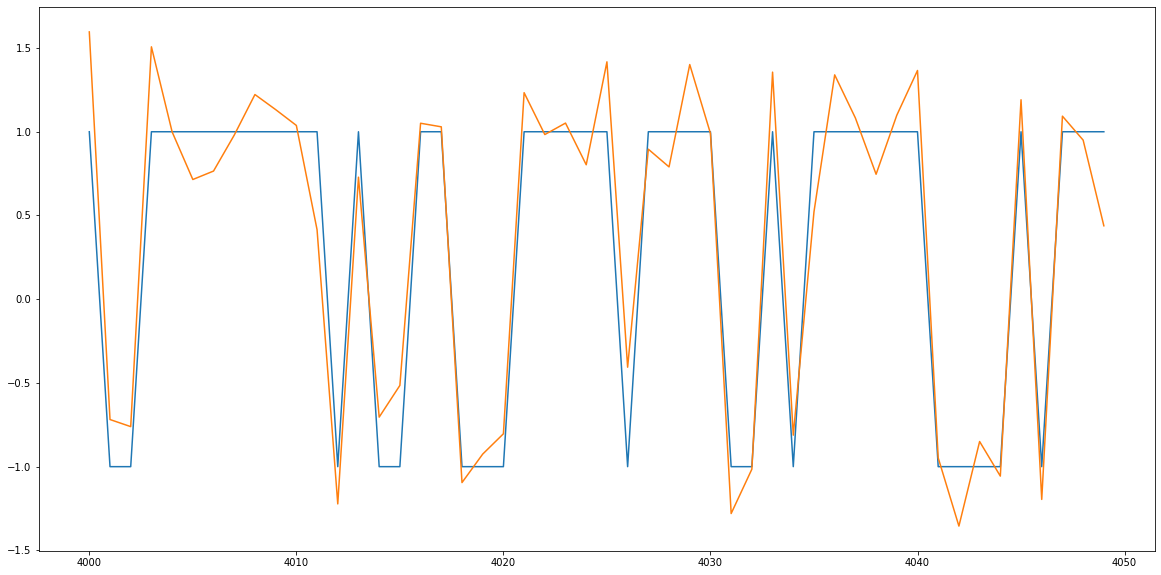

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(des[0][4000:4050])
plt.subplot()
plt.plot(dis[0][4000:4050])
plt.show()

**Scale Data**

In [ ]:
## Scale the data

def scale_data(X,y):
  scaler = MinMaxScaler()
  X = X.reshape(X.shape[0], X.shape[1])
  y = y.reshape(y.shape[0], y.shape[1])
  
  distorted_scaled = scaler.fit_transform(X)
  desired_scaled = scaler.fit_transform(y)
  
  distorted_scaled = distorted_scaled.reshape(distorted_scaled.shape[0], distorted_scaled.shape[1], 1)
  desired_scaled = desired_scaled.reshape(desired_scaled.shape[0], desired_scaled.shape[1], 1)

  return distorted_scaled, desired_scaled

In [ ]:
distorted_scaled, desired_scaled = scale_data(distorted, desired)
print(distorted_scaled.shape, desired_scaled.shape)

(6250, 16, 1) (6250, 16, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


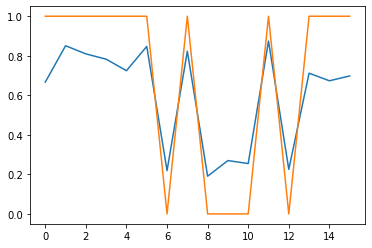

In [ ]:
plt.plot(distorted_scaled[0])
plt.subplot()
plt.plot(desired_scaled[0])

**Train Test Split**

In [ ]:
def train_test(x,y,train_test_split):
  percentage_training = math.floor((1 - train_test_split) * len(x))
  noisy_input, noisy_input_test = x[:percentage_training], x[percentage_training:]
  pure_input, pure_input_test = y[:percentage_training], y[percentage_training:]

  return noisy_input, noisy_input_test, pure_input, pure_input_test,percentage_training

In [ ]:
noisy_input , noisy_input_test, pure_input, pure_input_test, percentage_training = train_test(distorted_scaled, desired_scaled, 0.4)

In [ ]:
print('noisy_input shape=', noisy_input.shape, '\nnoisy_input_test shape=', noisy_input_test.shape, '\npure_input shape=', pure_input.shape, '\npure_input_test shape=', pure_input_test.shape)

noisy_input shape= (3750, 16, 1) 
noisy_input_test shape= (2500, 16, 1) 
pure_input shape= (3750, 16, 1) 
pure_input_test shape= (2500, 16, 1)


**Build Model**

In [ ]:
# Model configuration
input_shape = (16, 1)
batch_size = 10
no_epochs = 35
# train_test_split = 0.4
validation_split = 0.1
verbosity = 1
max_norm_value = 2.0

In [ ]:
model = Sequential()
model.add(Conv1D(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 32)           3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 128)          12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 1)             385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

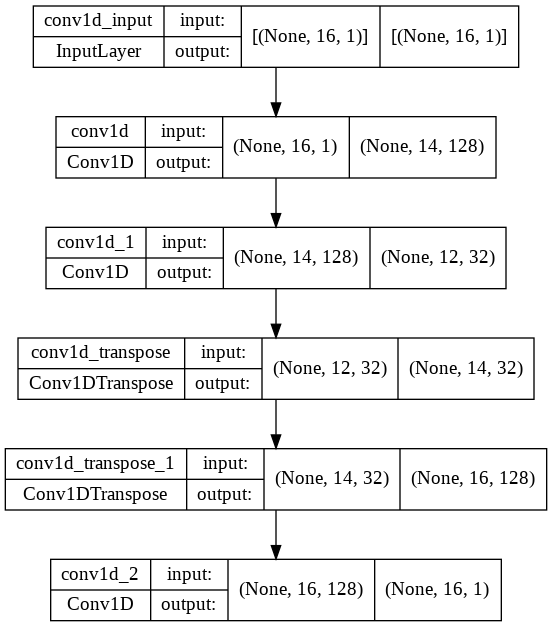

In [ ]:
dot_img_file = 'model_1.png'
tensorflow.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

**Plotting Results**

<Figure size 2160x720 with 0 Axes>

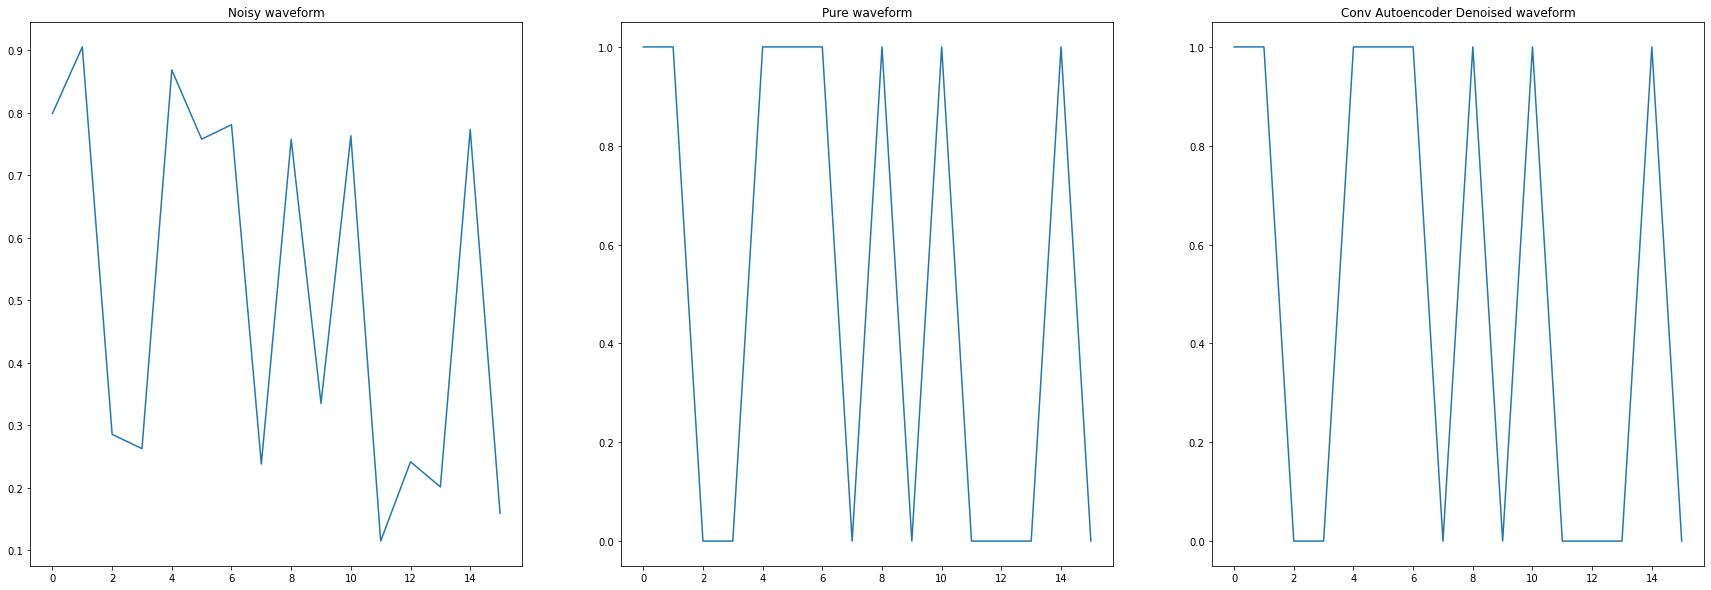

<Figure size 2160x720 with 0 Axes>

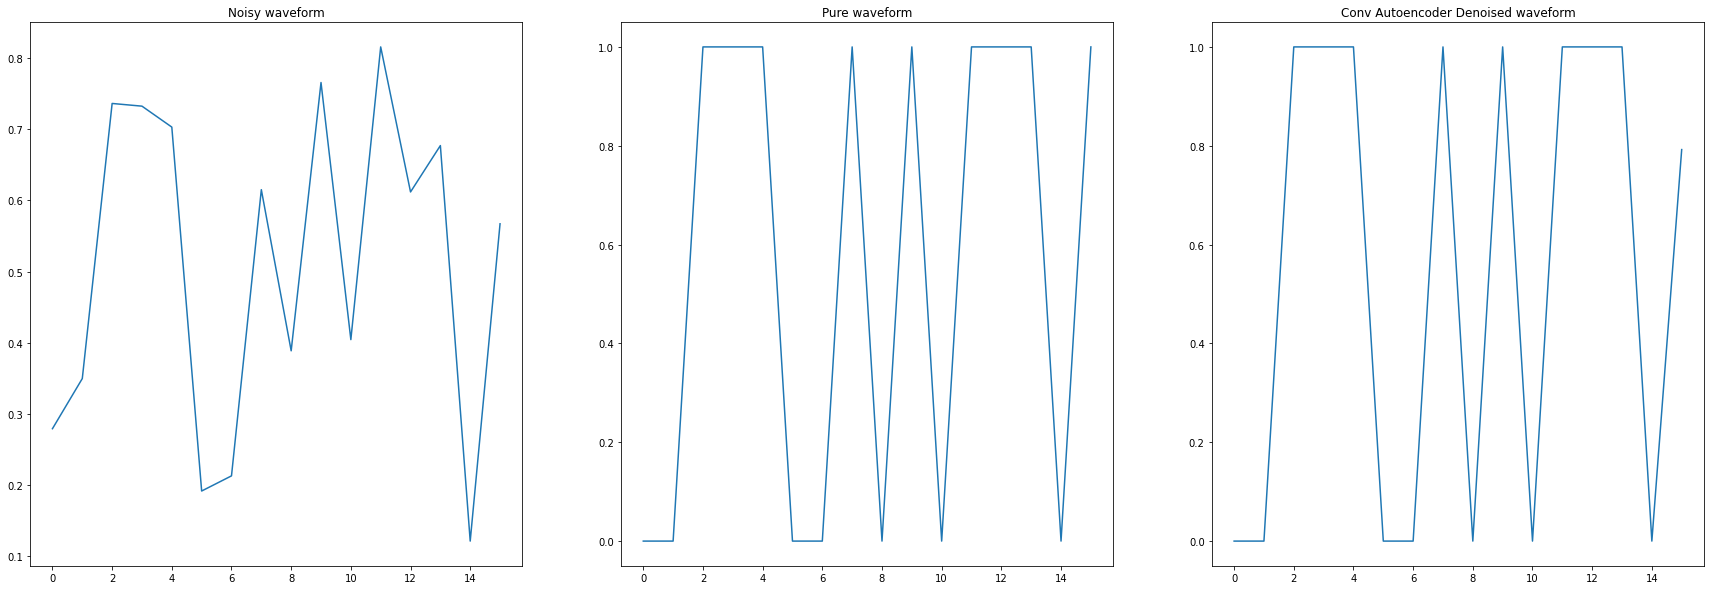

<Figure size 2160x720 with 0 Axes>

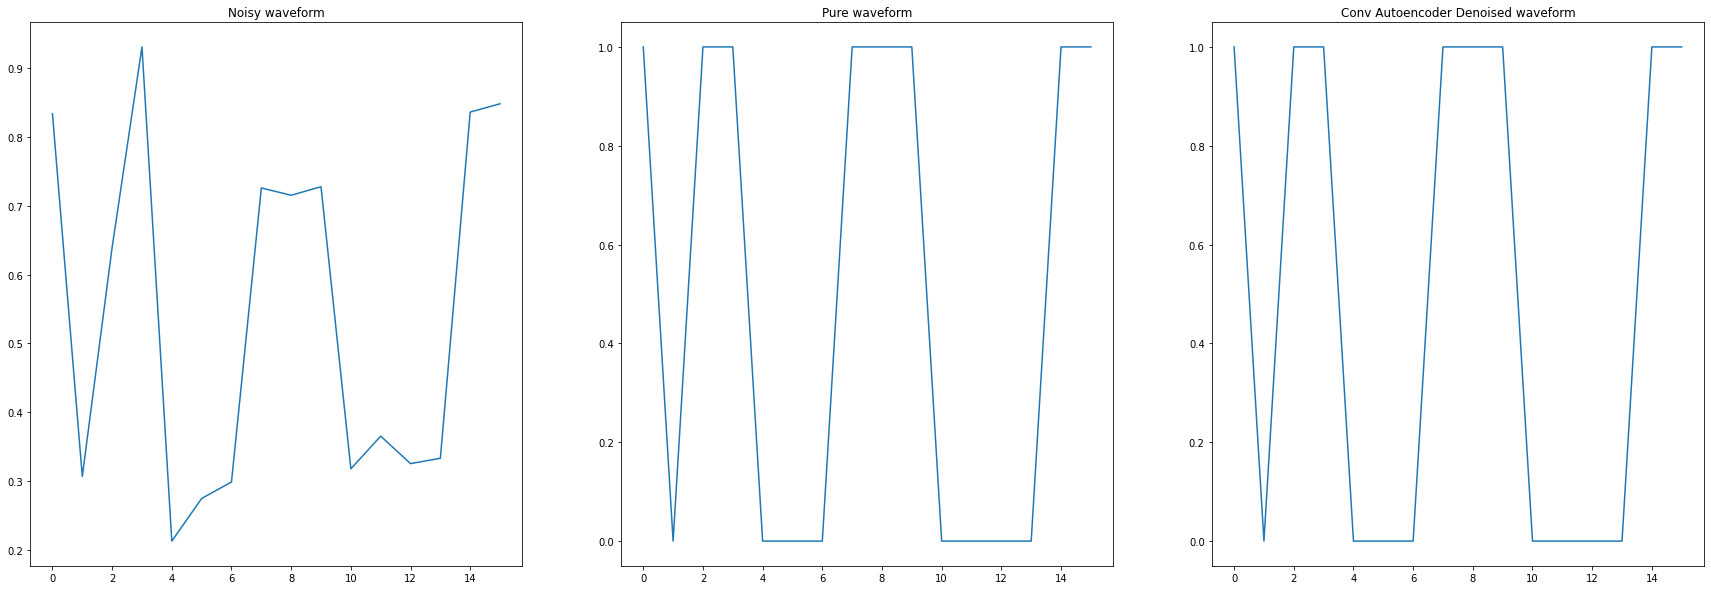

<Figure size 2160x720 with 0 Axes>

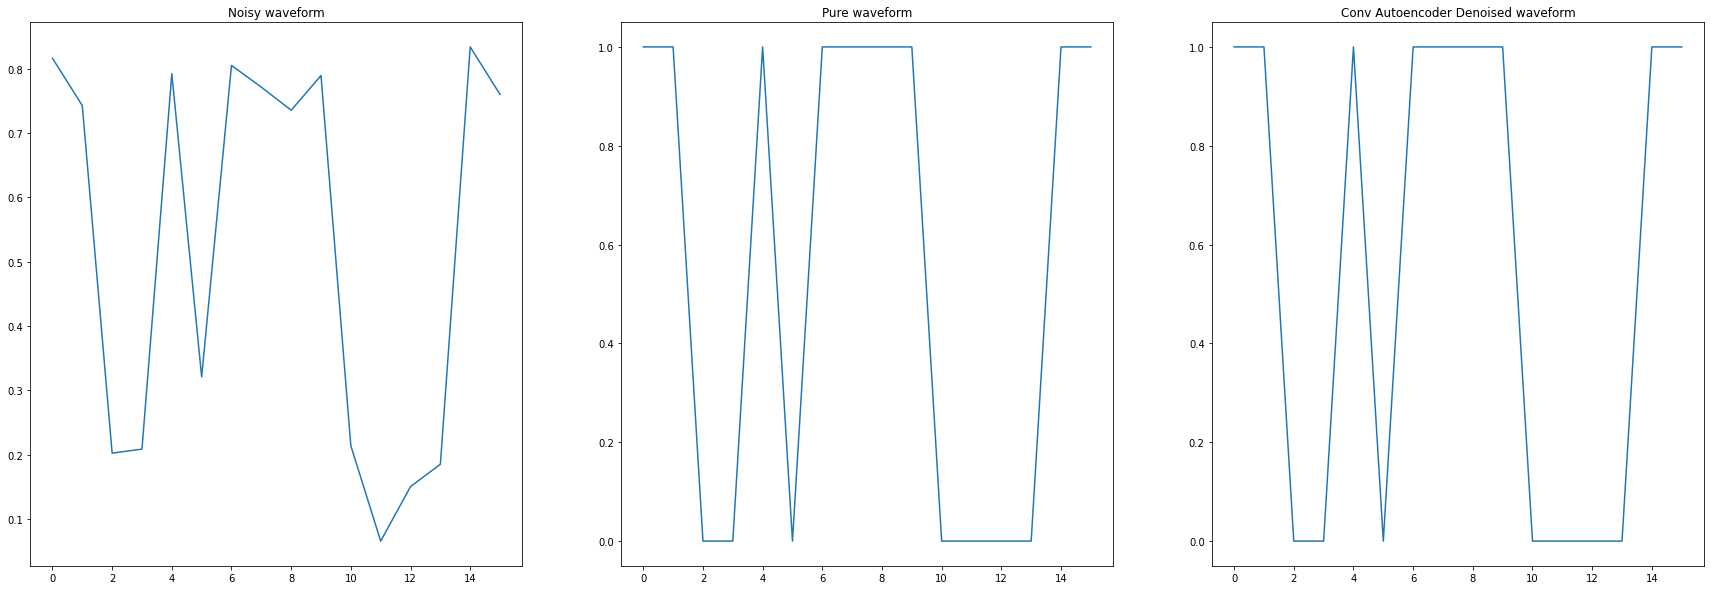

In [ ]:
# Generate reconstructions
num_reconstructions = 4
samples = noisy_input_test[:num_reconstructions]
reconstructions = model.predict(samples)

# Plot reconstructions
for i in np.arange(0, num_reconstructions):
  # Prediction index
  prediction_index = i + percentage_training
  # Get the sample and the reconstruction
  original = distorted_scaled[prediction_index]
  pure = desired_scaled[prediction_index]
  reconstruction = np.array(reconstructions[i])
  # Matplotlib preparations
  plt.figure(figsize=(30,10))
  fig, axes = plt.subplots(1, 3, figsize=(30,10))
  # Plot sample and reconstruciton
  axes[0].plot(original)
  axes[0].set_title('Noisy waveform')
  axes[1].plot(pure)
  axes[1].set_title('Pure waveform')
  axes[2].plot(reconstruction)
  axes[2].set_title('Conv Autoencoder Denoised waveform')
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


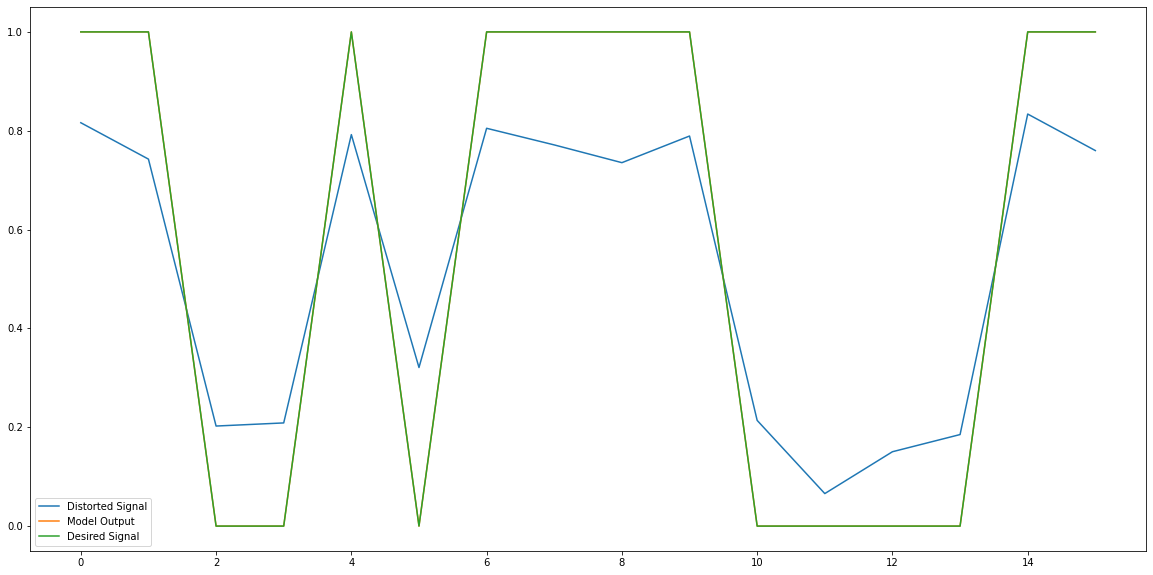

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(original, label='Distorted Signal')
plt.subplot()
plt.plot(reconstruction, label='Model Output')
plt.plot(pure, label='Desired Signal')
plt.legend()
plt.show()

In [ ]:
num = noisy_input_test.shape[0]*noisy_input_test.shape[1]
out = model.predict(noisy_input_test)

out = out.reshape(num)
df = pd.DataFrame(out)

dis_sc = noisy_input_test.reshape(num)
des_sc = pure_input_test.reshape(num)
df1 = pd.DataFrame(dis_sc)
df2 = pd.DataFrame(des_sc)

**Denormalize data**

In [ ]:
def minMaxDenormalize(y, a, b):
  x = (y * (b - a) + a)
  return x

In [ ]:
dff=minMaxDenormalize(df,-1,1)
dff1=minMaxDenormalize(df1,-1,1)
dff2=minMaxDenormalize(df2,-1,1)

**Ploting Graph**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


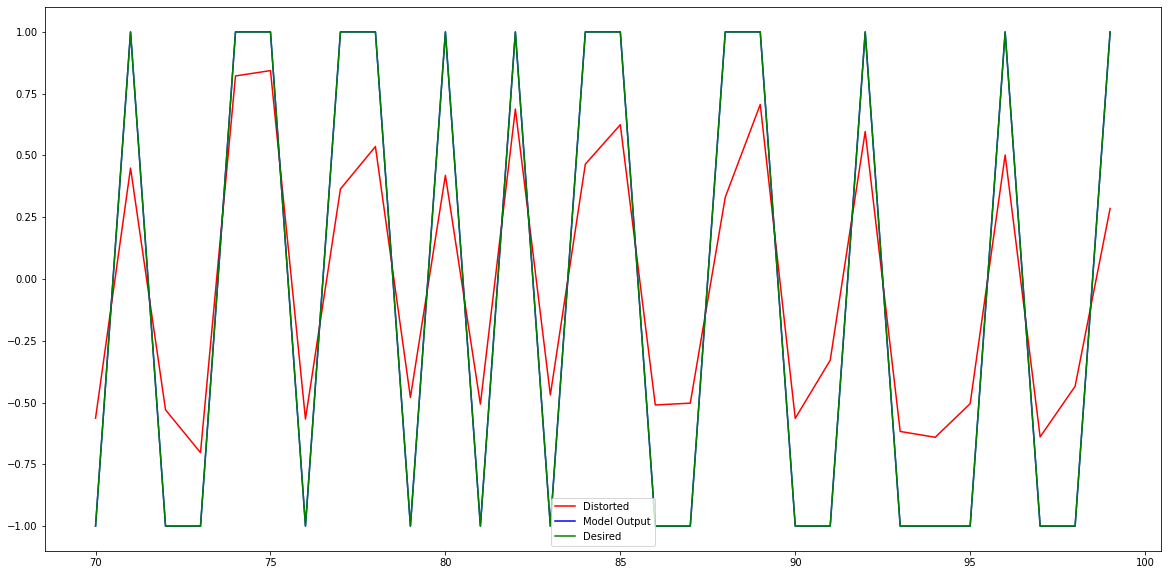

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dff1[0][70:100],'r', label='Distorted')
plt.subplot()
plt.plot(dff[0][70:100],'b', label='Model Output')
plt.plot(dff2[0][70:100], 'g', label='Desired')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(des_sc, out)

0.0005784689119955917

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df2, df)

0.00042502534558039925

In [ ]:
d = {'Mean Absoulute Error':0.0005784689119955917,'Mean Squared Error': 0.00042502534558039925}
error = pd.DataFrame(data=d, index=[0])
error

,Mean Absoulute Error,Mean Squared Error
0,0.000578,0.000425


In [ ]:
model.save('/content/drive/MyDrive/ofdm data/model/my_model1.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load Saved Model**

In [ ]:
check = tensorflow.keras.models.load_model('/content/drive/MyDrive/my_model1.h5')

**Create Data Packets**

In [ ]:
dis35 = pd.read_excel("/content/drive/MyDrive/ofdm data/distorted35.xls", header=None)
des35 = pd.read_excel("/content/drive/MyDrive/ofdm data/desired35.xls", header=None)

In [ ]:
def create_packets(data):
  sample = []
  xs = []
  rn = len(data)

  if rn%16 == 0:
    pass
  else:
    rn = rn - rn%16

  for i in range(0,rn,16):
    xs.append(data[0][i:i+16])

    sample.append(xs)
    xs = []

  sample = np.array(sample)
  sample = sample.reshape(int(rn/16), 16, 1)
  return(sample)

In [ ]:
dis_chk = create_packets(dis35)
des_chk = create_packets(des35)

In [ ]:
scl_dis_chk ,  scl_des_chk = scale_data(dis_chk, des_chk)

In [ ]:
full_out = check.predict(scl_dis_chk)
full_out = full_out.reshape(len(scl_dis_chk)*16)
desired_scaled = scl_des_chk.reshape(len(scl_des_chk)*16)
# dff=minMaxDenormalize(full_out,-1,1)
# dff1=minMaxDenormalize(desired_scaled,-1,1)
from sklearn.metrics import mean_squared_error
mean_squared_error(desired_scaled, full_out)

0.4740328596892581

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


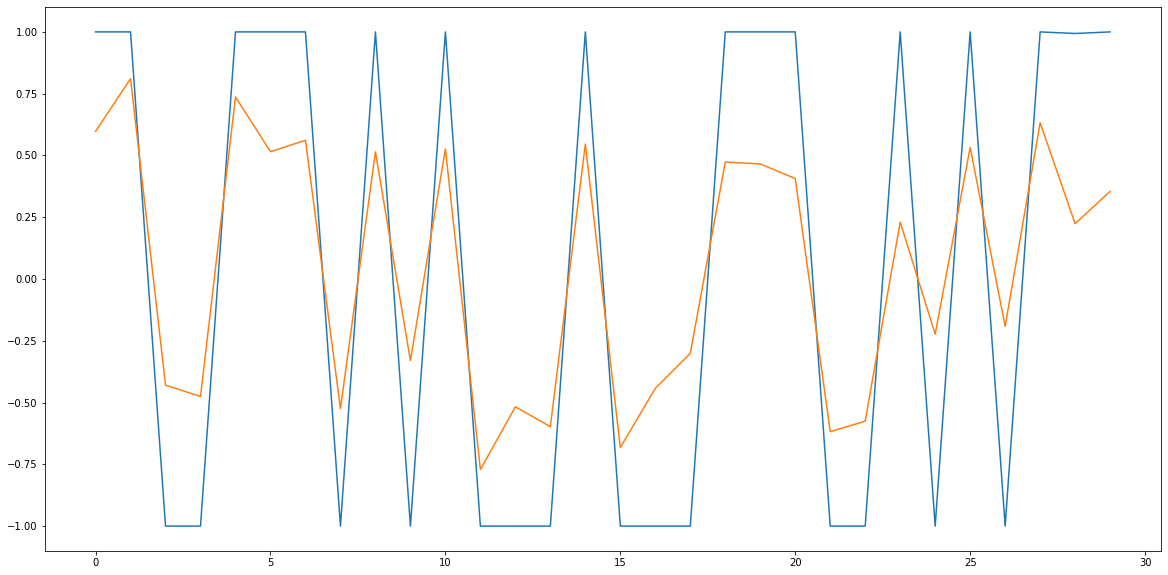

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dff[0:30])
plt.subplot()
plt.plot(dff1[0:30])